In [565]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [566]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [567]:
# 查看列的数据类型和缺失情况
print(train.info())
print()
print(train.isnull())
# isnull对每个单元格判断是不是缺失值，返回值是一个dataframe，数据为bool类型
print()
print(train.isnull().sum())
# .sum()对每一列按行相加，得到每列缺失值的个数

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

     PassengerId  Survived  Pclass   Name    Sex    Age  SibSp  Parch  Ticket  \
0          False     False   False  False  False  False  False  False   False   
1          False     False   False  False  False  False  False  False   Fals

# 处理缺失值

In [568]:
# 年龄和港口

train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
# fillna表示填充缺失值
# mode表示众数，[0]是因为众数可能有很多个，这里取第一个
# inplace=True表示就地操作，不开新内存

C:\Users\tks11\AppData\Local\Temp\ipykernel_25904\1448729455.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
C:\Users\tks11\AppData\Local\Temp\ipykernel_25904\1448729455.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


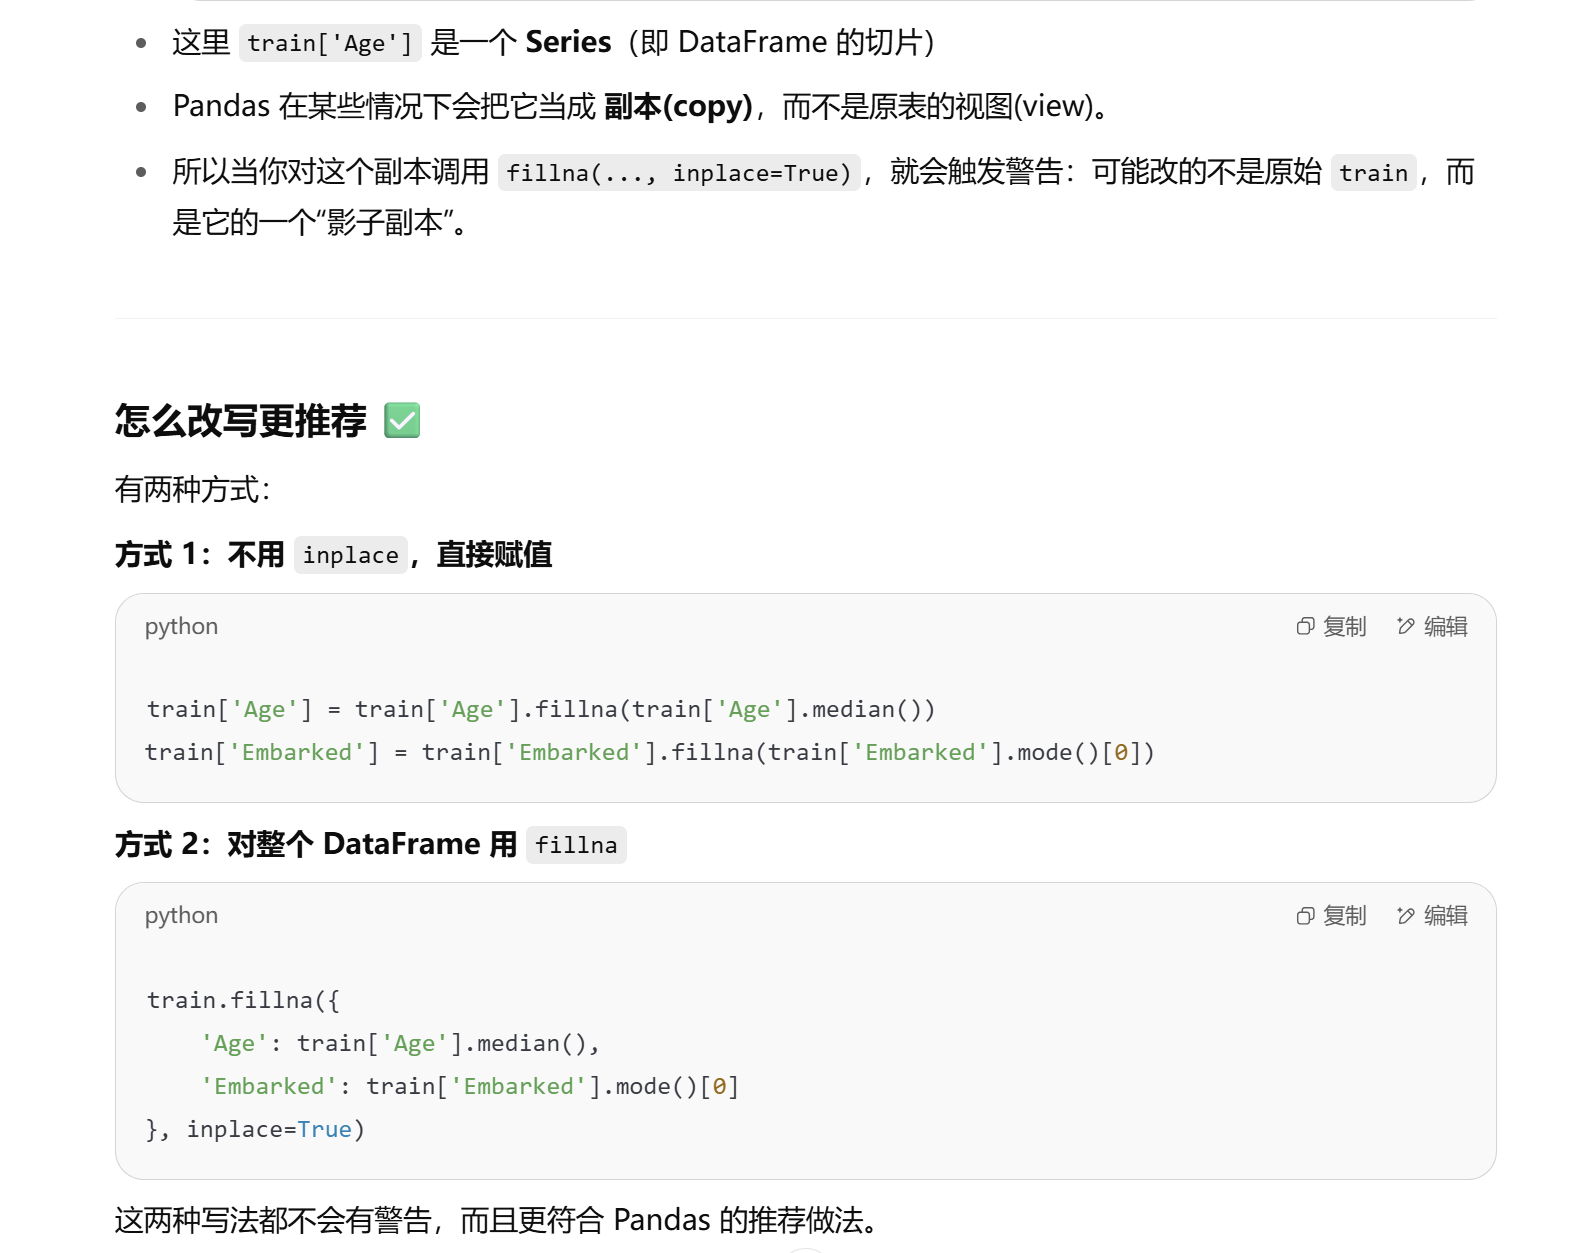
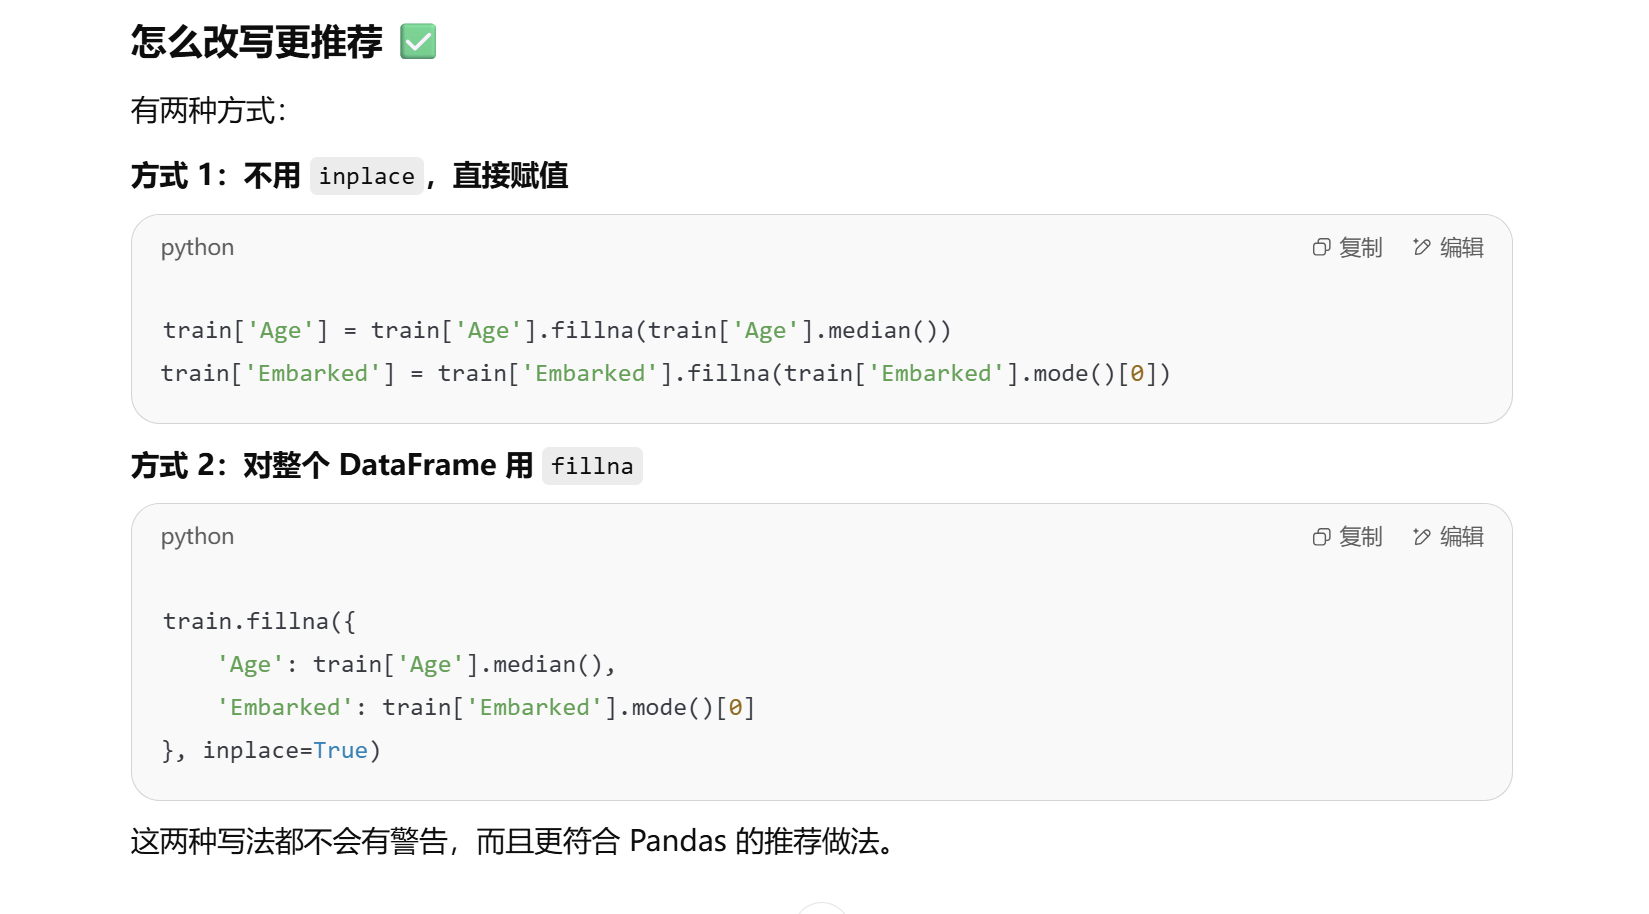

In [569]:
# 处理Cabin缺失值
# 因为缺失值太多，所以只区分Has_cabin

for df in (train, test):
    # 新增二元特征：是否有舱位
    df["HasCabin"] = df["Cabin"].notnull().astype(int)
    # 删掉原始 Cabin 列
    df.drop(columns=["Cabin"], inplace=True)

# 检查一下
print(train[["HasCabin", "Pclass", "Survived"]].head(10))
print(train["HasCabin"].value_counts(dropna=False))
# value_counts统计每个元素出现的次数
# value_counts的返回值是Series，即带索引的数组

   HasCabin  Pclass  Survived
0         0       3         0
1         1       1         1
2         0       3         1
3         1       1         1
4         0       3         0
5         0       3         0
6         1       1         0
7         0       3         0
8         0       3         1
9         0       2         1
HasCabin
0    687
1    204
Name: count, dtype: int64


# One-Hot编码

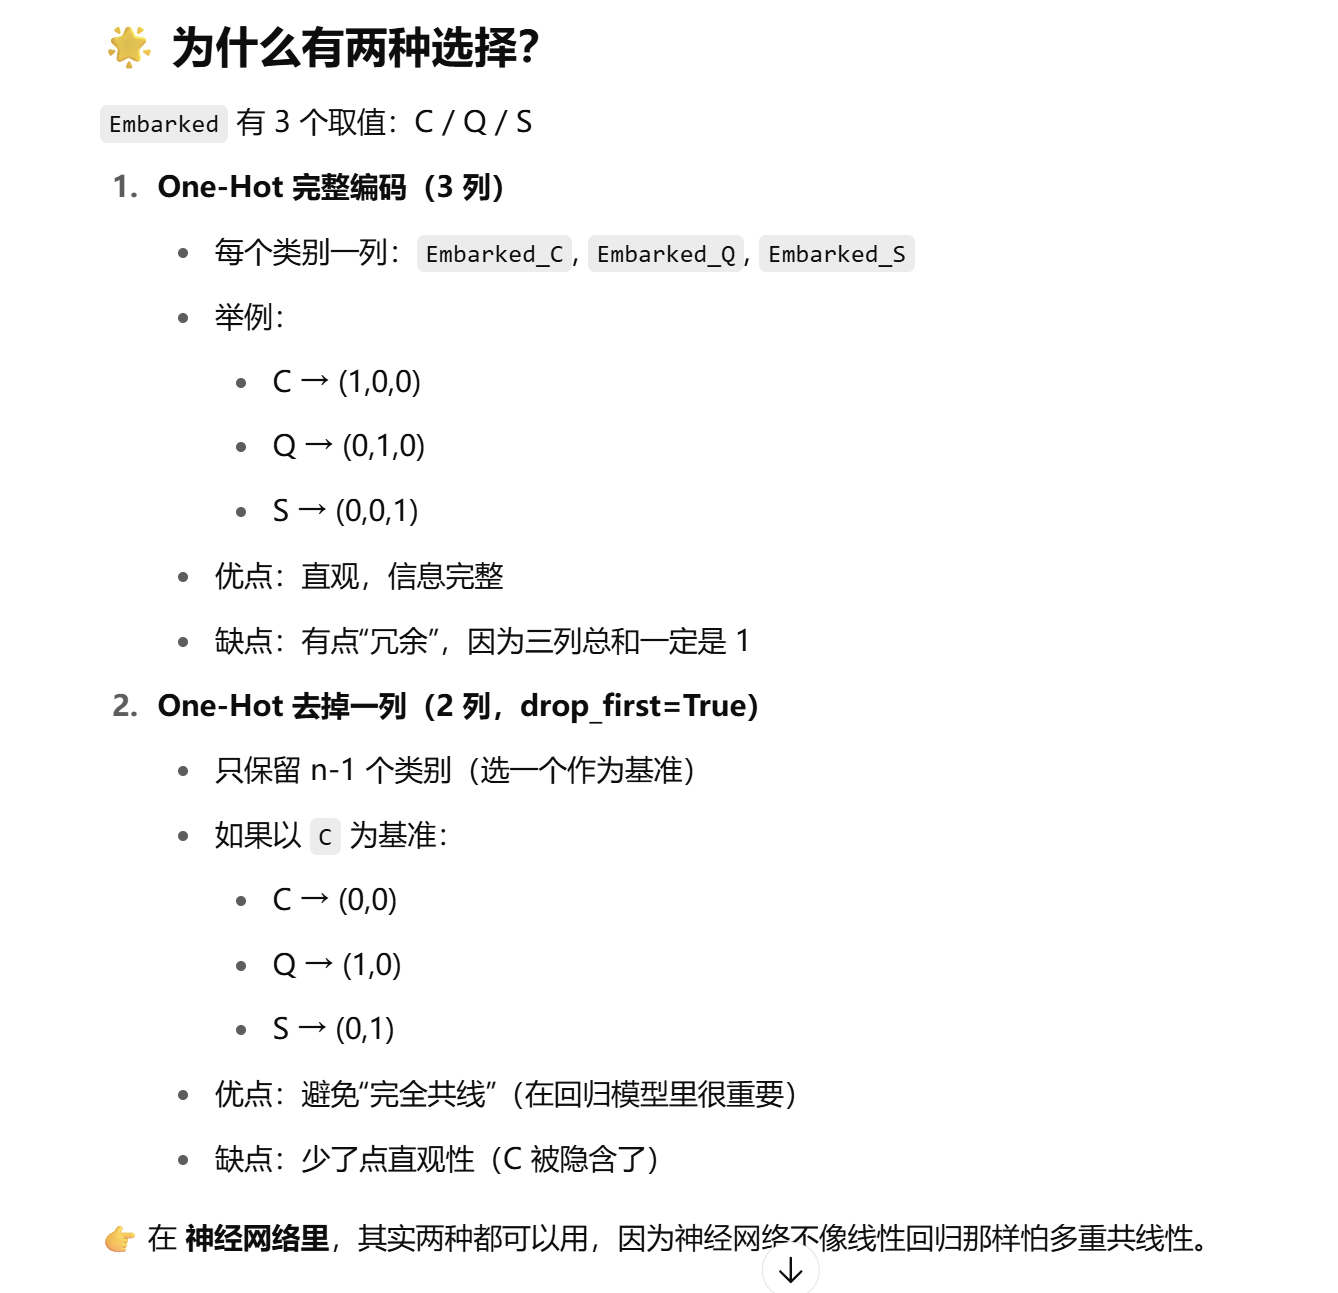

这里我们使用第二种选择

In [570]:
embarked_cats = ['C', 'Q', 'S']

for df in (train, test):
    # 把 df['Embarked'] 明确转换为“分类类型”，并指定所有可能的类别
    df['Embarked'] = pd.Categorical(df['Embarked'], categories=embarked_cats)
    # 显式定义这个特征的全部可能取值（顺序也固定）
    # Categorical 是 Pandas 的“分类类型”，类似把一列字符串声明成受限的离散取值。
    # 指定 categories 以后：
    # 这列只能取 C/Q/S（缺失仍是 NaN，不会被擅自当作新类别）。
    # 顺序被固定（重要！下一步 get_dummies(drop_first=True) 会按这个顺序丢掉“第一类”，因此我们能控制到底丢谁）。

    # 去掉一列，只留两列
    embarked_ohe_drop = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True)
    # get.dummies是one-hot编码函数，把类别变成0/1多列
    # prefix表示前缀，prefix='Embarked'意思是新列会叫Embarked_C, Embarked_Q, Embarked_S
    # drop_first=True表示丢掉第一列，避免完全共线

    # 删掉原始的字符串序列
    df.drop(columns=['Embarked'], inplace=True)
    # 去掉原始的字符串列，防止后续误读

    # 拼接到df
    df[embarked_ohe_drop.columns] = embarked_ohe_drop
    # 把新产生的 One-Hot 列拼回原 DataFrame。
    # 拼接位置是表格最右端

## 性别特征二元编码

In [571]:
for df in (train, test):
    # 统一小写并去空白，防止意外脏数据
    df["Sex"] = df["Sex"].str.strip().str.lower()
    # .str：Pandas 的字符串访问器，让你能对整列一次性地用“字符串函数”（而不是写 for 循环逐个处理）。
    # .strip()：去掉首尾空白字符（空格、制表符、换行等）。
    # .lower()：把字符串转小写

    # 二元编码：male=1, female=0
    df["Sex"] = (df["Sex"] == "male").astype(int)

# 简单检查
print(train["Sex"].value_counts(dropna=False))
# .value_counts统计唯一取值的频数
# dropna=False表示把NaN也统计进去

print(test["Sex"].value_counts(dropna=False))
print(train[["Sex", "Survived"]].head())

Sex
1    577
0    314
Name: count, dtype: int64
Sex
1    266
0    152
Name: count, dtype: int64
   Sex  Survived
0    1         0
1    0         1
2    0         1
3    0         1
4    1         0


### 构造家庭相关特征

In [572]:
# 在 Titanic 里，两个字段能描述家庭情况
# SibSp：兄弟姐妹 / 配偶数量
# Parch：父母 / 子女数量

for df in (train, test):
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

print(train[["SibSp", "Parch", "FamilySize", "IsAlone"]].head(10))


   SibSp  Parch  FamilySize  IsAlone
0      1      0           2        0
1      1      0           2        0
2      0      0           1        1
3      1      0           2        0
4      0      0           1        1
5      0      0           1        1
6      0      0           1        1
7      3      1           5        0
8      0      2           3        0
9      1      0           2        0


### 从Name提取称呼


In [573]:
import re  # 导入python的正则表达式模块

for df in (train, test):
    # 用正则从名字中提取 "逗号后+点号前" 的那部分
    df["Title"] = df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)

print(train[["Name", "Title"]].head(10))
print(train["Title"].value_counts())


                                                Name   Title
0                            Braund, Mr. Owen Harris      Mr
1  Cumings, Mrs. John Bradley (Florence Briggs Th...     Mrs
2                             Heikkinen, Miss. Laina    Miss
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)     Mrs
4                           Allen, Mr. William Henry      Mr
5                                   Moran, Mr. James      Mr
6                            McCarthy, Mr. Timothy J      Mr
7                     Palsson, Master. Gosta Leonard  Master
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)     Mrs
9                Nasser, Mrs. Nicholas (Adele Achem)     Mrs
Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jon

### 对Title特征编码

In [574]:
# 分组映射
title_map = {
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master"
}

for df in (train, test):
    df["Title"] = df["Title"].map(title_map).fillna("Rare")
    # One-Hot 编码
    title_ohe = pd.get_dummies(df["Title"], prefix="Title")
    df.drop(columns=["Title"], inplace=True)
    df[title_ohe.columns] = title_ohe

print(train.head())
print(train.filter(like="Title").head(10))


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare  HasCabin  Embarked_Q  Embarked_S  FamilySize  \
0         A/5 21171   7.2500         0       False        True           2   
1          PC 17599  71.2833         1       False       False           2   
2  STON/O2. 3101282   7.9250         0       False        True

# 处理Fare的缺失-->对数变换-->标准化

In [575]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 先基于 train 计算每个 Pclass 的 Fare 中位数
fare_median_by_pclass = train.groupby("Pclass")["Fare"].median()


def fill_fare_by_pclass(df):
    # 对 df 里 Fare 为 NaN 的行，按它的 Pclass 补上对应中位数
    missing_mask = df["Fare"].isna()
    df.loc[missing_mask, "Fare"] = df.loc[missing_mask, "Pclass"].map(fare_median_by_pclass)

for df in (train, test):
    fill_fare_by_pclass(df)

print("缺失检查：", train["Fare"].isna().sum(), test["Fare"].isna().sum())


# 缓解偏态
for df in (train, test):
    df["FareLog"] = np.log1p(df["Fare"])


# 标准化
scaler = StandardScaler()

num_cols_to_scale = ["Age", "Fare", "FareLog", "FamilySize"]  # 你也可以只缩放 Age/FareLog，看你偏好
train[num_cols_to_scale] = scaler.fit_transform(train[num_cols_to_scale])
test[num_cols_to_scale]  = scaler.transform(test[num_cols_to_scale])

print(train[num_cols_to_scale].describe().round(3))


缺失检查： 0 0
           Age     Fare  FareLog  FamilySize
count  891.000  891.000  891.000     891.000
mean     0.000    0.000   -0.000      -0.000
std      1.001    1.001    1.001       1.001
min     -2.224   -0.648   -3.059      -0.561
25%     -0.566   -0.489   -0.800      -0.561
50%     -0.105   -0.357   -0.232      -0.561
75%      0.433   -0.024    0.520       0.059
max      3.892    9.667    3.385       5.640


# 把Pclass当作类别编码

In [576]:
import pandas as pd

pclass_cats = [1, 2, 3]

for df in (train, test):
    # 显式转成“分类类型”，并指定完整类别集合
    df["Pclass"] = pd.Categorical(df["Pclass"], categories=pclass_cats)

    # 生成 One-Hot：Pclass_1, Pclass_2, Pclass_3
    pclass_ohe = pd.get_dummies(df["Pclass"], prefix="Pclass", drop_first=False)

    # 删掉原始列，拼回新列
    df.drop(columns=["Pclass"], inplace=True)
    df[pclass_ohe.columns] = pclass_ohe

# 简单检查
print(train.filter(like="Pclass_").head())





   Pclass_1  Pclass_2  Pclass_3
0     False     False      True
1      True     False     False
2     False     False      True
3      True     False     False
4     False     False      True


### 清理无用列

In [577]:
drop_cols = ["PassengerId", "Name", "Ticket", "Fare"]
train.drop(columns=drop_cols, inplace=True, errors="ignore")
test.drop(columns=drop_cols, inplace=True, errors="ignore")


### 统一将one-hot编码的bool类型转换成整型0/1

In [578]:
for df in (train, test):
    bool_cols = df.select_dtypes("bool").columns
    df[bool_cols] = df[bool_cols].astype(int)


### 明确矩阵X与标签y

In [579]:
X_train = train.drop(columns=["Survived"])
y_train = train["Survived"]

X_test = test.copy()  # Kaggle 提交时会用


# 简单检查
print("训练集特征形状：", X_train.shape)
print("训练集标签形状：", y_train.shape)
print("测试集特征形状：", X_test.shape)
print("特征示例：")
print(X_train.head())


训练集特征形状： (891, 18)
训练集标签形状： (891,)
测试集特征形状： (418, 18)
特征示例：
   Sex       Age  SibSp  Parch  HasCabin  Embarked_Q  Embarked_S  FamilySize  \
0    1 -0.565736      1      0         0           0           1    0.059160   
1    0  0.663861      1      0         1           0           0    0.059160   
2    0 -0.258337      0      0         0           0           1   -0.560975   
3    0  0.433312      1      0         1           0           1    0.059160   
4    1  0.433312      0      0         0           0           1   -0.560975   

   IsAlone  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  \
0        0             0           0         1          0           0   
1        0             0           0         0          1           0   
2        1             0           1         0          0           0   
3        0             0           0         0          1           0   
4        1             0           0         1          0           0   

    FareLog  Pclass_

# 获取张量，切分数据，创建数据加载器

In [580]:
import torch

X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.long)  # 分类任务用 long
print(X_tensor.shape, y_tensor.shape)
# y的形状是N，因为crossEntropy的要求


# 拆分训练集和验证集
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
)



from torch.utils.data import TensorDataset, DataLoader
# TensorDataset：把特征和标签打包成一个“数据集对象”。
# DataLoader：负责按 batch 取数据、打乱顺序、在训练时循环读取。
train_ds = TensorDataset(X_tr, y_tr)
val_ds = TensorDataset(X_val, y_val)
# 每次 dataset[i] 会返回 (X_tensor[i], y_tensor[i]) → 一个样本和它的标签
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
# 帮你把数据分成小批量（batch），并在每个 epoch 自动打乱（如果 shuffle=True）。

import torch.nn as nn

class TitanicNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # 输出 2 类：0=遇难，1=生还
        )
    def forward(self, x):
        return self.model(x)

model = TitanicNet(X_tensor.shape[1])
print(model)



torch.Size([891, 18]) torch.Size([891])
TitanicNet(
  (model): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [581]:
import torch.optim as optim

# 损失函数：交叉熵，适合分类（内部会做 softmax）
criterion = nn.CrossEntropyLoss()

# 优化器：Adam (学习率 0.001 常用起点)
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 训练、验证循环

In [582]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    # ---- 训练 ----
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        # 将张量移到gpu上

        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * Xb.size(0)
        # loss.item()是该批次数据的平均损失，乘Xb.size(0)，即批次大小，等于该批次总损失
        pred = out.argmax(1)  # 每行取最大logits的类别索引
        # 相当于argmax(dim=1)，在第1维，即列方向上找最大值索引
        # pred是一维向量，长度是batchsize
        train_correct += (pred == yb).sum().item()
        train_total += yb.size(0)
        # 统计本批预测正确数与样本数，累加到全 epoch

    train_loss /= train_total  # 计算该epoch平均误差，
    train_acc = train_correct / train_total  # 计算该epoch预测准确率

    # ---- 验证 ----
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            pred = out.argmax(1)
            val_correct += (pred == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1:02d}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict()

model.load_state_dict(best_state)
print("最佳验证准确率:", best_acc)

cuda
Epoch 01: train_loss=0.6870, train_acc=0.5730, val_acc=0.7654
Epoch 02: train_loss=0.5915, train_acc=0.7683, val_acc=0.7654
Epoch 03: train_loss=0.4871, train_acc=0.7837, val_acc=0.8045
Epoch 04: train_loss=0.4389, train_acc=0.8301, val_acc=0.8212
Epoch 05: train_loss=0.4155, train_acc=0.8258, val_acc=0.8212
Epoch 06: train_loss=0.4036, train_acc=0.8287, val_acc=0.8212
Epoch 07: train_loss=0.3976, train_acc=0.8371, val_acc=0.8436
Epoch 08: train_loss=0.3917, train_acc=0.8441, val_acc=0.8380
Epoch 09: train_loss=0.3876, train_acc=0.8357, val_acc=0.8436
Epoch 10: train_loss=0.3817, train_acc=0.8469, val_acc=0.8156
最佳验证准确率: 0.8435754189944135


# 优化

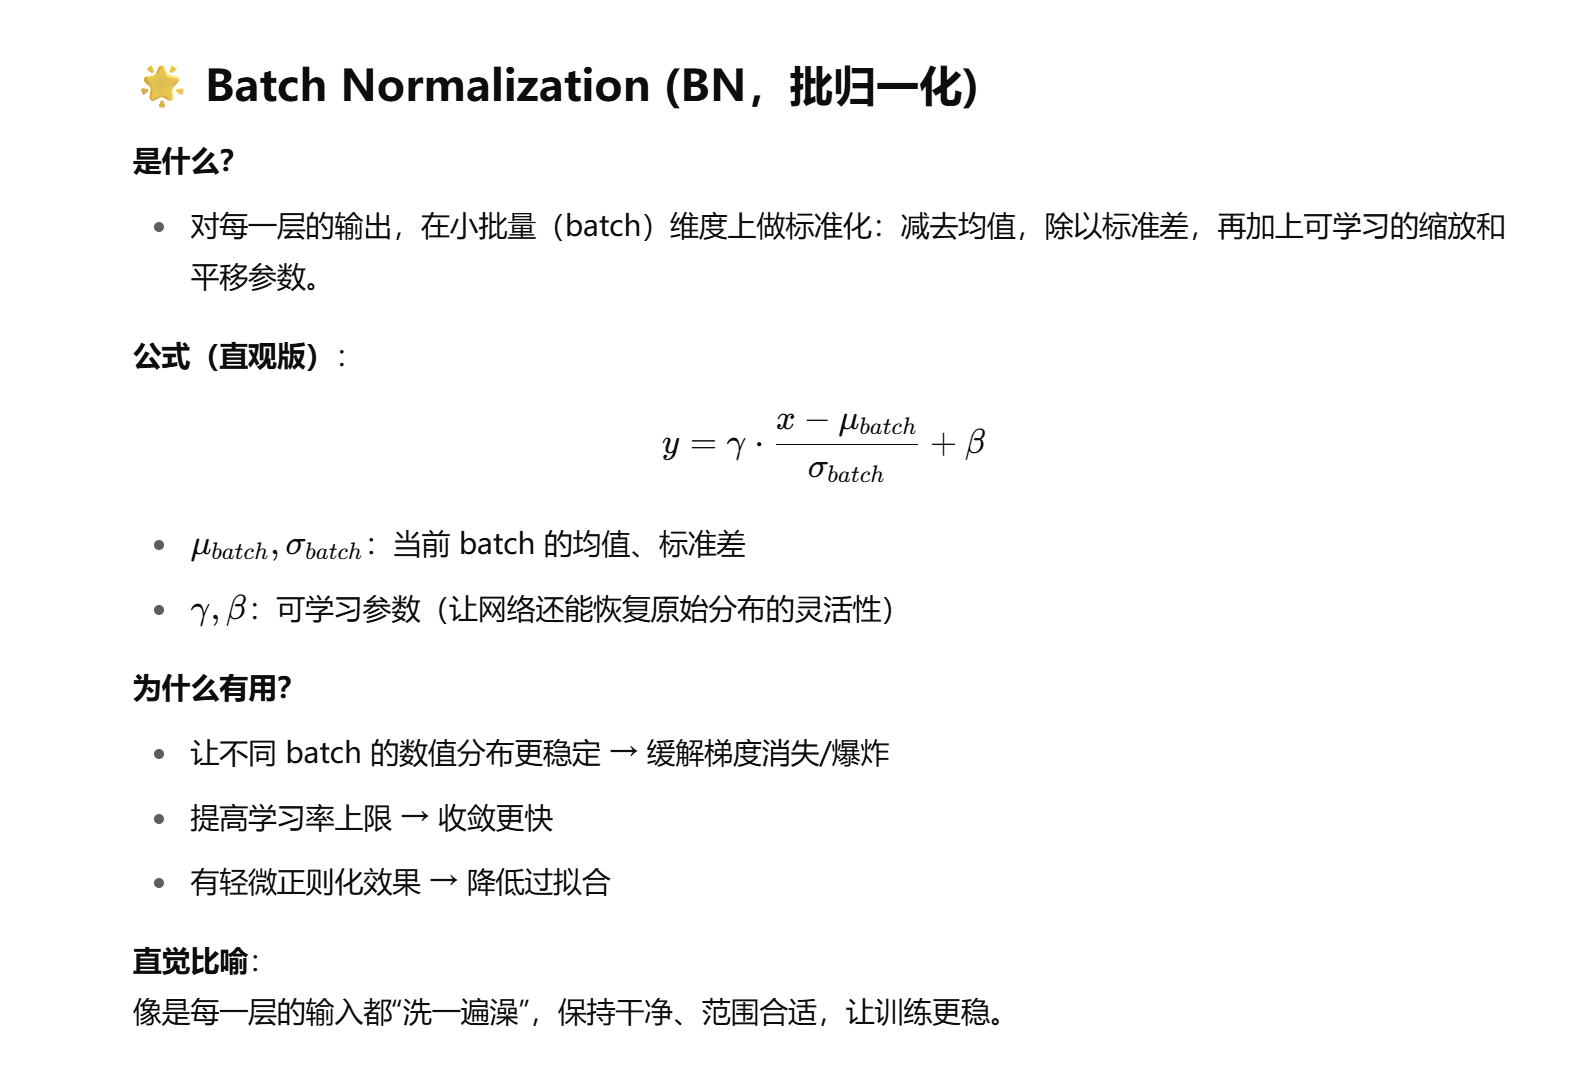
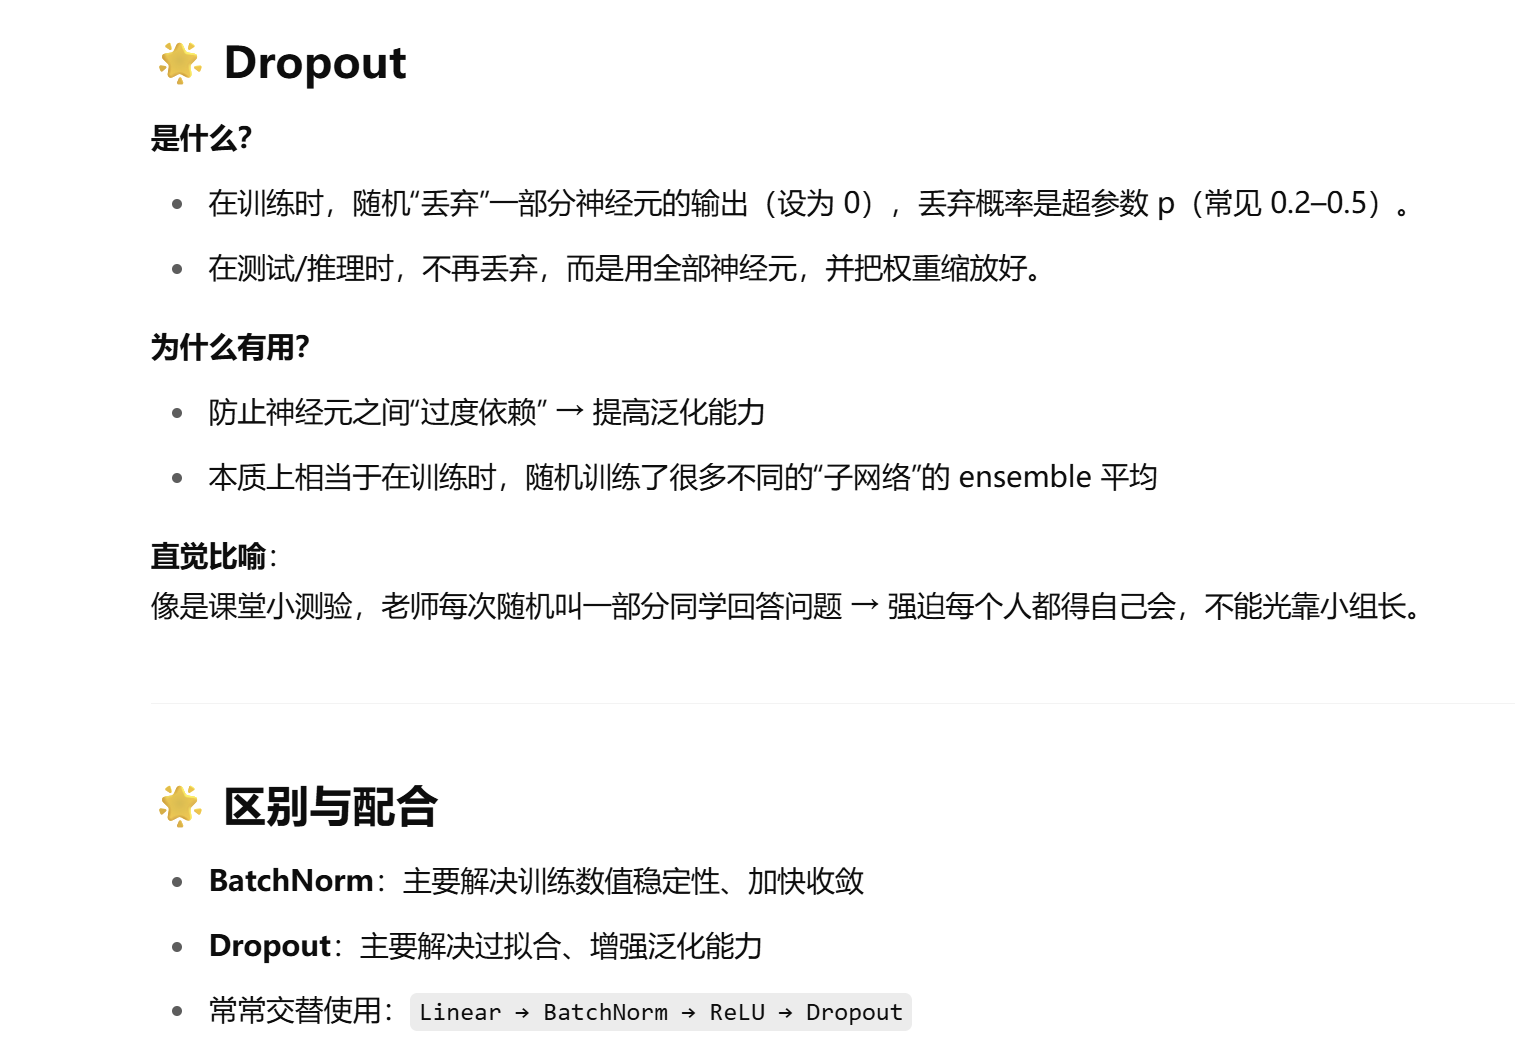

In [583]:
class TitanicNetBNDrop(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),   # BN 稳定分布
            nn.ReLU(),
            # nn.Dropout(p=0.3),     # 随机丢弃 30%

            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Dropout(p=0.1),

            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.Dropout(p=0.1),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            # nn.Dropout(p=0.1),


            nn.Linear(32, 2)       # 输出层：2 类
        )
    def forward(self, x):
        return self.net(x)

modelBND = TitanicNetBNDrop(X_train.shape[1])
print(modelBND)

TitanicNetBNDrop(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [584]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-6)


In [585]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 200
best_acc = 0.0

for epoch in range(epochs):
    # ---- 训练 ----
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        # 将张量移到gpu上

        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * Xb.size(0)
        # loss.item()是该批次数据的平均损失，乘Xb.size(0)，即批次大小，等于该批次总损失
        pred = out.argmax(1)  # 每行取最大logits的类别索引
        # 相当于argmax(dim=1)，在第1维，即列方向上找最大值索引
        # pred是一维向量，长度是batchsize
        train_correct += (pred == yb).sum().item()
        train_total += yb.size(0)
        # 统计本批预测正确数与样本数，累加到全 epoch

    train_loss /= train_total  # 计算该epoch平均误差，
    train_acc = train_correct / train_total  # 计算该epoch预测准确率

    # ---- 验证 ----
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            pred = out.argmax(1)
            val_correct += (pred == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1:02d}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict()

model.load_state_dict(best_state)
print("最佳验证准确率:", best_acc)

Epoch 01: train_loss=0.3823, train_acc=0.8427, val_acc=0.8268
Epoch 02: train_loss=0.3760, train_acc=0.8553, val_acc=0.8380
Epoch 03: train_loss=0.3737, train_acc=0.8427, val_acc=0.7989
Epoch 04: train_loss=0.3754, train_acc=0.8511, val_acc=0.8156
Epoch 05: train_loss=0.3720, train_acc=0.8567, val_acc=0.8212
Epoch 06: train_loss=0.3674, train_acc=0.8469, val_acc=0.8212
Epoch 07: train_loss=0.3654, train_acc=0.8553, val_acc=0.8212
Epoch 08: train_loss=0.3616, train_acc=0.8525, val_acc=0.8156
Epoch 09: train_loss=0.3651, train_acc=0.8511, val_acc=0.8156
Epoch 10: train_loss=0.3589, train_acc=0.8511, val_acc=0.8045
Epoch 11: train_loss=0.3565, train_acc=0.8553, val_acc=0.8101
Epoch 12: train_loss=0.3587, train_acc=0.8539, val_acc=0.8101
Epoch 13: train_loss=0.3574, train_acc=0.8511, val_acc=0.8045
Epoch 14: train_loss=0.3516, train_acc=0.8539, val_acc=0.8045
Epoch 15: train_loss=0.3505, train_acc=0.8638, val_acc=0.8101
Epoch 16: train_loss=0.3491, train_acc=0.8624, val_acc=0.8045
Epoch 17

# 生成并保存测试结果

In [586]:
test_ids = pd.read_csv("data/test.csv")["PassengerId"]  # 路径按你的实际放置
print(len(test_ids), test_ids.head())



418 0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64


In [587]:
with torch.no_grad():
    Xte_tensor = torch.tensor(X_test.values, dtype=torch.float32, device=device)
    logits = model(Xte_tensor)                 # (418, 2)
    preds  = logits.argmax(1).cpu().numpy()    # 0/1

### 组装提交文件并保存

In [588]:
sub = pd.DataFrame({"PassengerId": test_ids, "Survived": preds.astype(int)})
assert len(sub) == 418 and set(sub["Survived"].unique()) <= {0,1}
sub.to_csv("submission.csv", index=False)
print(sub.head(), "\nSaved -> submission.csv")


   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0 
Saved -> submission.csv
